# Sumário

Este experimento demostra os passos para construir um modelo preditivo com solução para manutenção.

# Introdução

A manutenção preditiva é o acompanhamento periódico de equipamentos ou máquinas através de dados coletados por meio de monitoração ou inspeção. Ela possui várias técnicas e é a mais rentável das manutenções uma vez que ela age antes da falha ocorrer. Neste projeto faremos a previsão da deterioração do equipamento para que a manutenção seja planejada com antecedência.
O conjunto de dados utilizado é a versão do [Kaggle](https://www.kaggle.com/behrad3d/nasa-cmaps) de degradação de ativos da NASA, onde inclui dados simulados Run-to-Fail de motores turbo fan jet. A simulação da degradação do motor foi realizado usando C-MAPSS (mais detalhes aqui: [C-MAPSS](https://software.nasa.gov/software/LEW-18315-2)). O registro é realizado através de vários canais de sensores.

## Objetivo da predição

Iremos prever o tempo de vida útil restante, ou Remaining Useful Life (RUL) de cada motor no dataset. RUL é equivalente ao número de voos restante.

## Cenário Experimental

* Os conjuntos de dados consistem em várias séries temporais multivariadas. 
* Cada conjunto de dados é dividido em subconjuntos de treinamento e teste. 
* Cada série temporal é de um motor diferente, ou seja, os dados podem ser considerados de uma frota de motores do mesmo tipo. 
* Cada motor dá partida com diferentes graus de desgaste inicial e variação de fabricação desconhecidos do usuário. Este desgaste e variação são considerados normais, ou seja, não é considerada uma condição de falha. Existem três configurações operacionais que têm um efeito substancial no desempenho do motor. Essas configurações também estão incluídas nos dados. Os dados estão contaminados com ruído do sensor.

O motor está operando normalmente no início de cada série temporal e desenvolve uma falha em algum ponto durante a série. No conjunto de treinamento, a falha cresce em magnitude até a falha do sistema. No conjunto de teste, a série temporal termina algum tempo antes da falha do sistema. O objetivo é prever o número de ciclos operacionais restantes antes da falha no conjunto de teste, ou seja, o número de ciclos operacionais após o último ciclo que o motor continuará a operar. Também é fornecido um vetor de valores reais de vida útil restante (RUL) para os dados de teste.

## Metodologia

A metodologia utilizada será a do CRISP-DM (Cross Industry Standard Process for Data Mining), ela reúne as melhores práticas para projetos com dados. O CRISP-DM é um modelo cíclico com etapas estabelecidas, sendo possível entregar respostas aos interessados enquanto melhoramos e compreendemos melhor o nosso modelo em cada ciclo.

Para mais detalhes [aqui](https://www.datascience-pm.com/crisp-dm-2/).

O projeto inclui uma coleção de modelos de aprendizado de máquinas pré-configurados, bem como scripts em Python, para habilitar uma solução de ponta à ponta do processamento de dados ao **deploy** do modelo.
> "Deploy" é a implementação de um sistema em desenvolvimento.




# Importar as Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from boruta import BorutaPy

## Funções

In [2]:
# notebook settings
def notebook_settings():
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [14,10]
    plt.rcParams['font.size'] = 10
    
# functions to calculate models metrics
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat) 
    mse = mean_squared_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({
        'model name' : model_name,
        'MAE' : mae,
        'MPE' : mse,
        'RMSE' : rmse
    }, index=[0])

# metrics for cross val score
def cross_validation(model_name, model, x, y, kfold):
    '''
    Metrics for cross validation score
    '''
    mae = cross_val_score(model, x, y, scoring='neg_mean_absolute_error', cv = kfold)
    mse = cross_val_score(model, x, y, scoring='neg_mean_squared_error', cv = kfold) 
    rmse = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv = kfold)

    return pd.DataFrame({
        'Model' : model_name,
        'MAE' : np.round(np.mean(-mae), 4), 
        'MSE' : np.round(np.mean(-mse), 4),
        'RSME' : np.round(np.mean(-rmse), 4),
    }, index=[0])  


In [3]:
notebook_settings()

# Etapa 1: Entendimento dos Dados

## Carregando Dados

Esta etapa visa conhecermos melhor o conjunto de dados, iremos fazer uma investigação. 

In [4]:
# utilizando a biblioteca pandas para importarmos o dataset
df_raw_train = pd.read_csv('data/CMaps/train_FD001.txt', 
                           parse_dates=False, delimiter=" ", decimal=".", header=None)
df_raw_test = pd.read_csv('data/CMaps/test_FD001.txt', 
                          parse_dates=False, delimiter=" ", decimal=".", header=None)
df_raw_results = pd.read_csv('data/CMaps/RUL_FD001.txt', 
                             parse_dates=False, delimiter=" ", decimal=".", header=None)

In [5]:
# vamos nomear as columas
cols = [
    'unit', 'cycles', 'setting1', 'setting2', 'setting3', 
    's1', 's2', 's3', 's4', 's5', 's6','s7', 's8', 's9', 's10', 
    's11', 's12', 's13', 's14','s15', 's16', 's17', 's18', 's19', 
    's20', 's21', 's22', 's23']
# mudando nome das colunas
df_raw_train.columns = cols
df_raw_test.columns = cols

In [6]:
# fazendo cópias dos dataframes
df_train = df_raw_train.copy()
df_test = df_raw_test.copy()

## Conhecendo os Dados

Aqui iremos ver detalhes sobre o conjunto de dados, suas unidades e como estão distribuidos.

In [7]:
# shape
print(f'O dataset de treino possui {df_train.shape[0]} linhas e {df_train.shape[1]} colunas')
print(f'O dataset de teste possui {df_test.shape[0]} linhas e {df_test.shape[1]} colunas')

O dataset de treino possui 20631 linhas e 28 colunas
O dataset de teste possui 13096 linhas e 28 colunas


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   unit      20631 non-null  int64  
 1   cycles    20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

Aparentemente o sensor 22 e o sensor 23 não possuem valores, não sabemos a causa mas inicialmente iremos removê-los. O sensor 17 e 18 possuem unidades diferentes dos demais, ele apresenta leituras em números inteiros.
Temos apenas valores numéricos.

As mesmas propriedades podem ser vistas aqui no dataset de teste.

## Estatística Descritiva

In [9]:
# vamos guardar a função describe do pandas numa variável
describe = df_train.describe().T
# adicionar range
describe['range'] = (df_train.max() - df_train.min()).tolist()
# adicionar skew
describe['skew'] = df_train.skew().tolist()
# adicionar kurtosis
describe['kurtosis'] = df_train.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,skew,kurtosis
unit,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000,99.0000,-0.067815,-1.219824
cycles,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000,361.0000,0.499904,-0.218539
setting1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087,0.0174,-0.024766,-0.009132
setting2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006,0.0012,0.009085,-1.130447
setting3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000,0.0000,0.000000,0.000000
s1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700,0.0000,0.000000,0.000000
s2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300,3.3200,0.316526,-0.112043
s3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100,45.8700,0.308946,0.007762
s4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900,59.2400,0.443194,-0.163681
s5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200,0.0000,0.000000,0.000000


**Algumas observações**:
* As colunas `setting3`, `s1`, `s10`, `s18` e `s19` possuem valores repetidos;
* As colunas `s5` e `s16` possuem variações tão baixas que são praticamente nulas;
* `s6`, `s9` e `s14` possuem skew alto;
* `s6`, `s9` e `s14` possuem um kurtosis grande;

## Filtrar Colunas

In [10]:
df_train = df_train.drop(columns=[
    'setting3','s1','s5','s10','s16','s18','s19','s22','s23'])
df_test = df_test.drop(columns=[
    'setting3','s1','s5','s10','s16','s18','s19','s22','s23'])

## Feature Engineering

Aqui iremos criar algumas novas variáveis, uma delas é a RUL, faremos uma inversão da tabela de ciclo, começando pelo ciclo máximo até o mínimo, a ideia aqui é mostrar quantos ciclos resta para o equipamento.

In [11]:
# vamos criar uma coluna com variáveis os números máximos de ciclo de cada engine
def rul_calculate_train(data):
    # setting max cycles from each unit
    max_col = pd.DataFrame(data.groupby('unit')['cycles'].max().reset_index())
    # merge
    data_1 = data.merge(max_col, on=['unit'], how='left')
    # RUL 
    data_1['rul'] = data_1['cycles_y'] - data_1['cycles_x']
    # vamos dropar as colunas com cycles_y e max
    data_1 = data_1.drop(columns=['cycles_y'])
    # rename column
    data_1 = data_1.rename(columns={'cycles_x':'cycles'})
    
    return data_1

In [12]:
# rul calculating for train
df_train = rul_calculate_train(df_train)

Agora vamos fazer o mesmo para o dataset de treino, nos arquivos RUL_FD001.txt temos a quantidade de ciclos restante até a falha, criaremos uma coluna `rul` baseado nesses dados.

In [13]:
# adjust results to merge in test dataframe
df_raw_results[1] = np.arange(1,101)
df_raw_results = df_raw_results.rename(columns={0:'left', 1:'unit'})

def rul_calculate_test(data, validation):
    # merge
    df = df_test.merge(validation, on=['unit'], how='left')
    max_col = df.groupby('unit')['cycles'].max().reset_index()
    data = df.merge(max_col, on=['unit'], how='left')
    data['rul'] = data['left'] + data['cycles_y']
    data = data.drop(['cycles_y', 'left'], axis=1)
    data = data.rename(columns={'cycles_x':'cycles'})

    return data
    

In [14]:
df_test = rul_calculate_test(df_test, df_raw_results)

Vamos criar mais duas variáveis de tipo classificatória, quando a máquina estiver a 30 dias para a falha e outra para quando a máquina estiver a 10 dias.

In [15]:
m = 30
m2 = 10

# coluna com 30 dias para falha
df_train['30_days'] = df_train['rul'].apply(lambda x: 1 if x <= m else 0)
df_test['30_days'] = df_test['rul'].apply(lambda x: 1 if x <= m else 0)
# coluna com 10 dias para falha
df_train['10_days'] = df_train['rul'].apply(lambda x: 1 if x <= m2 else 0)
df_test['10_days'] = df_test['rul'].apply(lambda x: 1 if x <= m2 else 0)

## Análise Exploratória de Dados

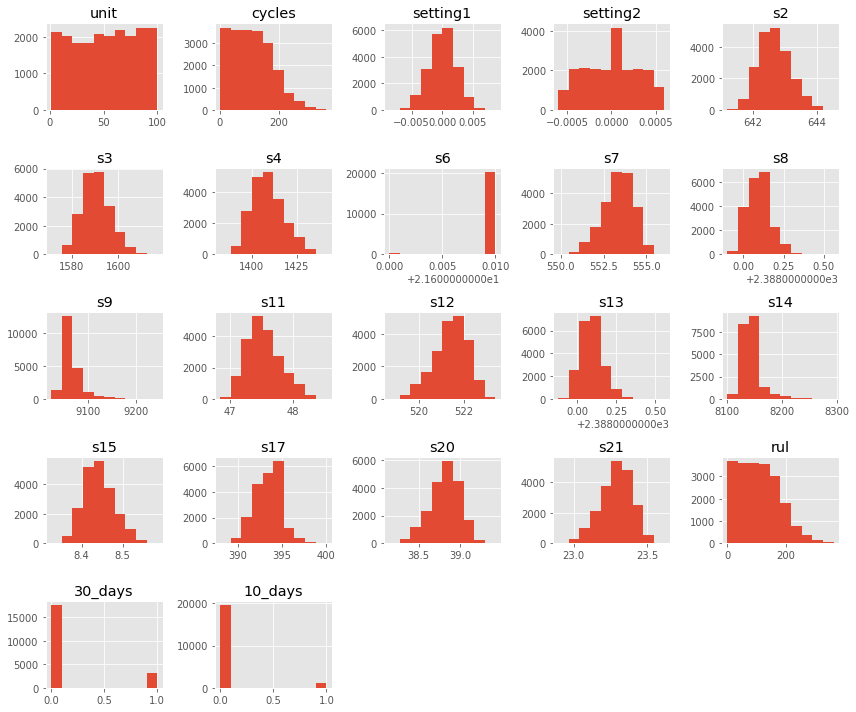

In [16]:
df_train.hist(figsize=(12,10))
plt.tight_layout();

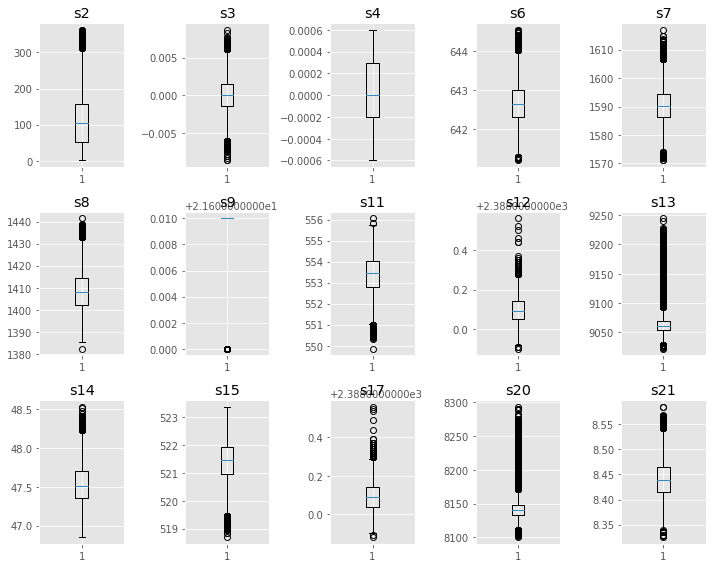

In [17]:
# vamos checar os sensores
columns = ['s2','s3','s4','s6','s7',
           's8','s9','s11','s12','s13',
           's14','s15','s17','s20','s21']

plt.figure(figsize=(10,8))
for i in range(len(columns)):
    plt.subplot(3, 5, i+1) 
    plt.boxplot(df_train.iloc[:,i+1])
    plt.title(f'{str(columns[i])}')
    plt.tight_layout()

Vamos plotar o sensor 9 para uma melhor visualização.

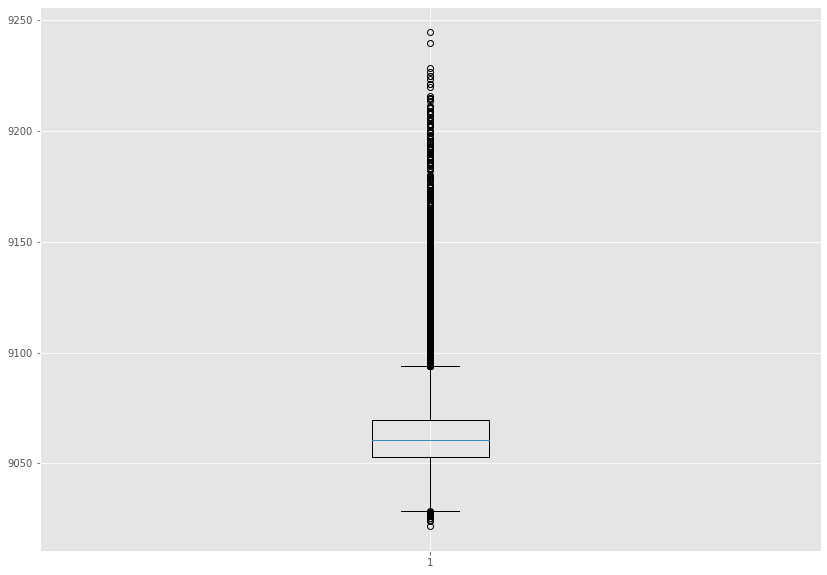

In [18]:
plt.boxplot(df_train.s9);

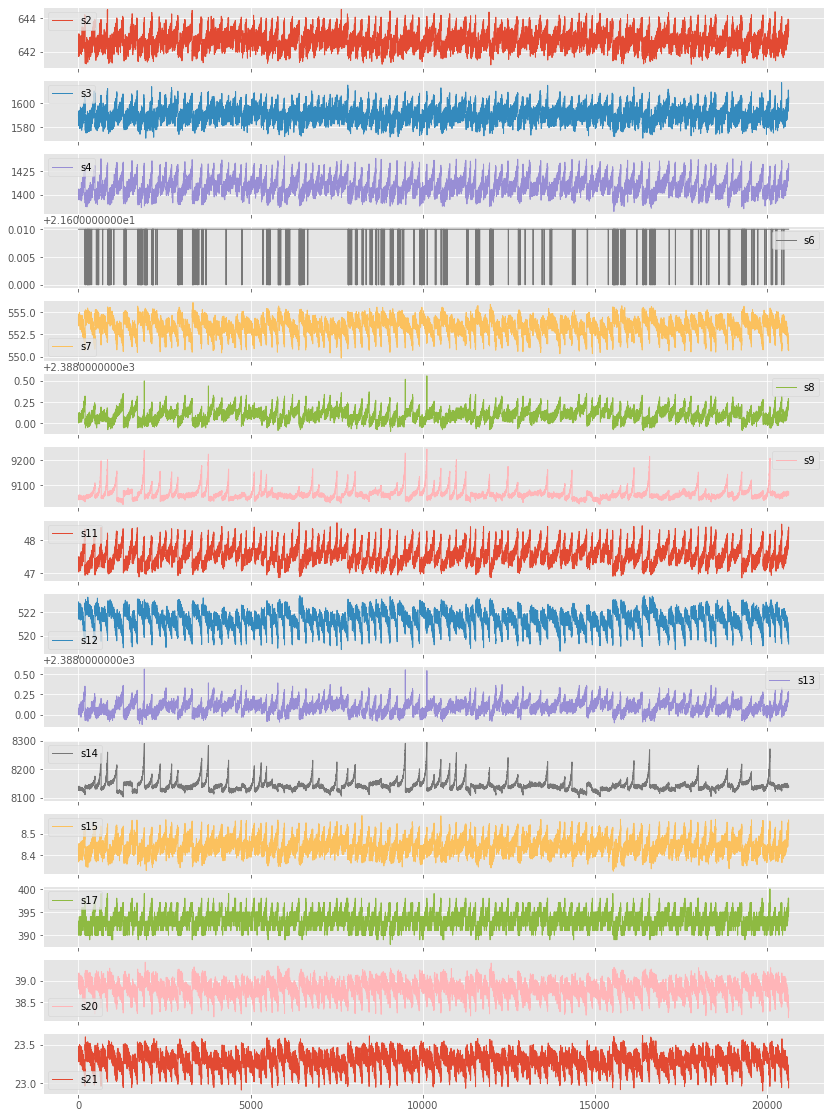

In [19]:
df_train[columns].plot(subplots=True, figsize=(14,20), linewidth=1, sharex=True);

## Análise Multivariada

Vamos analisar a correlação que todas as variáveis possuem com relação a variável alvo (RUL).

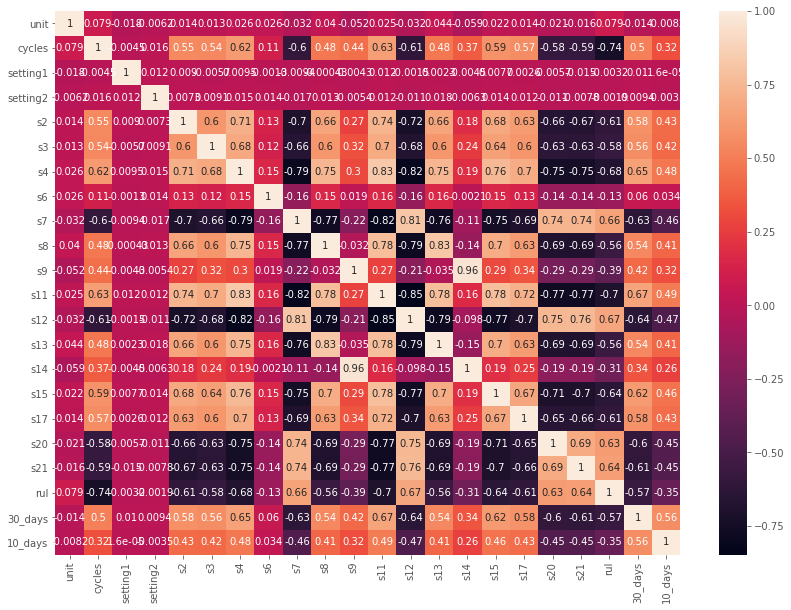

In [20]:
heat = df_train.corr(method='pearson')
sns.heatmap(heat, annot=True);

# Etapa 2: Preparo dos Dados

In [21]:
# copia o dataset para nova etapa
df1 = df_train.copy()
df2 = df_test.copy()

## Rescala

In [22]:
# instanciar robust scaler
rs = RobustScaler()

# sensor 6 train
df1['s6'] = rs.fit_transform(df1[['s6']].values)
# sensor 9 train
df1['s9'] = rs.fit_transform(df1[['s9']].values)
# sensor 14 train
df1['s14'] = rs.fit_transform(df1[['s14']].values)

# sensor 6 test
df2['s6'] = rs.fit_transform(df2[['s6']].values)
# sensor 9 test
df2['s9'] = rs.fit_transform(df2[['s9']].values)
# sensor 14 test
df2['s14'] = rs.fit_transform(df2[['s14']].values)

## Seleção de Features por Importância

### Dividir o Dataframe em Treino e Teste

In [23]:
X_train = df1.drop('rul', axis=1)
y_train = df1.rul
X_test = df2.drop('rul', axis=1)
y_test = df2.rul

In [24]:
X_train.shape, X_test.shape

((20631, 21), (13096, 21))

In [25]:
y_train.shape, y_test.shape

((20631,), (13096,))

## Boruta Como Selecionador de Variáveis

Nesta fase utilizaremos um algorítmo para selecionar as variáveis de acordo com sua importância, fortalecendo nossos modelos.

In [26]:
# training and test dataset for Boruta
X_train_n = X_train.values
Y_train_n = y_train.values.ravel()

# define random forest regressor
#rf = RandomForestRegressor()

# define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

In [27]:
# boruta ranking
#cols_selected = boruta.support_.tolist()

# select columns
#cols_selected_boruta = X_train.iloc[:, cols_selected].columns.to_list()
# not selected columns
#cols_not_selected_boruta = list(np.setdiff1d(X_train.columns, cols_selected_boruta))

In [28]:
#cols_selected_boruta

In [29]:
#cols_not_selected_boruta

In [30]:
cols_selected_boruta = ['unit',
 'cycles',
 's2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's20',
 's21']

cols_not_selected_boruta = ['10_days', 's17', 's6', 'setting1', 'setting2']

# Etapa 3: Modelos de Machine Learning

Usaremos 4 modelos de machine learning e ver qual deles performa melhor:
<ol>
<li> Dummy Regressor;</li>
<li> Linear Regression Model; </li>
<li> Linear regression Regularized Model - Lasso; </li>
<li> Decision Tree Regressor; </li>
<li> XGBoost Regressor. </li>
</ol>

In [31]:
# boruta columns selection
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# for cross validation
X_train_full = X_train[cols_selected_boruta]
y_train_full = y_train

cv = TimeSeriesSplit(n_splits=10)

## Average Model

In [32]:
# model
dr = DummyRegressor().fit( x_train, y_train )

# prediction
yhat_dr = dr.predict( x_test )

# performance
dr_result = ml_error('Dummy Regressor', y_test, yhat_dr)
dr_result

,model name,MAE,MPE,RMSE
0,Dummy Regressor,110.267123,14390.55678,119.960647


## Linear Regression Model

In [33]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr)
lr_result

,model name,MAE,MPE,RMSE
0,Linear Regression,83.337552,10739.79869,103.633


### Cross-Validation: Linear Regression

In [34]:
lr_result_cv = cross_validation('Linear Regressions CV', lr, X_train_full, y_train_full, cv)
lr_result_cv

,Model,MAE,MSE,RSME
0,Linear Regressions CV,31.6684,1804.5063,39.8935


## Linear Regression Regularized Model - Lasso

In [35]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test, yhat_lrr)
lrr_result

,model name,MAE,MPE,RMSE
0,Linear Regression - Lasso,83.33451,10740.906275,103.638344


### Cross-Validation: Lasso

In [36]:
lrr_result_cv = cross_validation('Lasso CV', lrr, X_train_full, y_train_full, cv)
lrr_result_cv

,Model,MAE,MSE,RSME
0,Lasso CV,31.6691,1804.7915,39.8934


##  Decision Tree Regressor

In [37]:
# model 
dt = DecisionTreeRegressor(random_state=42).fit(x_train, y_train)

# prediction
yhat_dt = dt.predict(x_test)

# performance
dt_results = ml_error('Decision Tree Regressor', y_test, yhat_dt)
dt_results

,model name,MAE,MPE,RMSE
0,Decision Tree Regressor,100.266799,14571.550244,120.712676


### Cross-Validation: Decision Tree Regressor

In [38]:
dt_result_cv = cross_validation('Decision Tree CV', dt, X_train_full, y_train_full, cv)
dt_result_cv

,Model,MAE,MSE,RSME
0,Decision Tree CV,40.3039,3361.6249,53.1304


## Random Forest Regressor

In [39]:
# model 
rf = RandomForestRegressor(random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_results = ml_error('Random Forest Regressor', y_test, yhat_dt)
rf_results

,model name,MAE,MPE,RMSE
0,Random Forest Regressor,100.266799,14571.550244,120.712676


In [40]:
rf_result_cv = cross_validation('Random Forest Regressor CV', rf, X_train_full, y_train_full, cv)
rf_result_cv

,Model,MAE,MSE,RSME
0,Random Forest Regressor CV,35.8112,2869.0387,48.134


# Etapa 4: Validação dos Modelos

## Single Performance

In [41]:
results_models = pd.concat([
    dr_result, lr_result, lrr_result, dt_results, rf_results]
).reset_index(drop=True)

results_models

,model name,MAE,MPE,RMSE
0,Dummy Regressor,110.267123,14390.556780,119.960647
1,Linear Regression,83.337552,10739.798690,103.633000
2,Linear Regression - Lasso,83.334510,10740.906275,103.638344
3,Decision Tree Regressor,100.266799,14571.550244,120.712676
4,Random Forest Regressor,100.266799,14571.550244,120.712676


## Real Performance

In [42]:
real_models = pd.concat([
    lr_result_cv, lrr_result_cv, dt_result_cv, rf_result_cv]
).reset_index(drop=True)

real_models

,Model,MAE,MSE,RSME
0,Linear Regressions CV,31.6684,1804.5063,39.8935
1,Lasso CV,31.6691,1804.7915,39.8934
2,Decision Tree CV,40.3039,3361.6249,53.1304
3,Random Forest Regressor CV,35.8112,2869.0387,48.1340


Entre os 4 modelos principais, temos que o Linear Regression e o Lasso tiveram melhores resultados, a Média de Erro Absoluto diz basicamente que: a média de todos os erros correspondem a erro de 30 ciclos da turbina. Podemos melhorar levemente essa taxa implementando um hyper-parameter fine tunning ou com criação de novas variáveis. 

## Próximas Etapas

* Fazer transformações em todas as features com influência de outliers;
* Criar novas features;
* Testar novos modelos;